In [155]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import random
import json

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

0it [00:00, ?it/s]

In [156]:
DATASET_RAW = "../datasets/flickr/raw"
DATASET_INTERIM = "../datasets/flickr/interim"
CHECKPOINTS = "../checkpoints/flickr"

## Load & clean captions

In [159]:
def clean_caption(caption, table):
    caption.replace("-", " ")    # Replace "-" with " "
    words = caption.split()      # Split the words
    
    words = [word.lower() for word in words]    # Convert to lowercase
    words = [word.translate(table) for word in words]  # Remove punctuations
    words = [word for word in words if(len(word)>1)]   # Remove 's and a
    words = [word for word in words if(word.isalpha())] # Remove tokens with numbers
    
    return f"<start>{' '.join(words)}<end>"


def load_captions(filename):
    # Load the text file into memory
    file = open(filename, 'r')
    text = file.read()
    file.close()
    table = str.maketrans('', '', string.punctuation)
    
    img_captions = dict()
    
    lines = text.split('\n')
    for line in lines[1:]:
        if len(line) == 0:
            continue
        img, caption = line.split(',', 1)
        # Clean the caption text
        caption = clean_caption(caption, table)
        if img in img_captions:
            img_captions[img].append(caption)
        else:
            img_captions[img] = [caption]
        
    return img_captions


img_captions = load_captions(os.path.join(DATASET_RAW, 'captions.txt'))
print(f"Number of captions: \t{len(img_captions)}")


Number of captions: 	8091


In [116]:
# # Save the cleaned captions to interim dir
# with open(os.path.join(DATASET_INTERIM, 'captions.json'), 'w') as file:
#     json.dump(img_captions, file)

In [158]:
with open(os.path.join(DATASET_INTERIM, 'captions.json'), 'rb') as file:
    img_captions = json.load(file)

## Extracting the features from images 

In [37]:
def extract_img_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0

        feature = model.predict(image)
        features[img] = feature
    return features

img_features = extract_img_features(os.path.join(DATASET_RAW, 'Images'))

# Save the extracted image features to interim dir
dump(img_features, open(os.path.join(DATASET_INTERIM, 'img_features.pkl'), 'wb'))

2023-11-04 20:07:09.421439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-04 20:07:09.475971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-04 20:07:09.477446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-04 20:07:09.479969: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

83697664/83683744 [==============================] - 1s 0us/step


/tmp/ipykernel_703/3649821741.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

2023-11-04 20:07:18.987298: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-11-04 20:07:23.180721: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2023-11-04 20:07:27.142004: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [160]:
img_features = load(open(os.path.join(DATASET_INTERIM, 'img_features.pkl'),"rb"))

print(f"# of images: {len(img_features)}")
print(f"Dimension of an image feature {img_features[list(img_features.keys())[0]].shape}")

# of images: 8091
Dimension of an image feature (1, 2048)


## Split the training/dev/test set

In [161]:
img_files = list(img_captions.keys())

assert len(img_files) > 7000, "The list must have more than 7000 elements."

# Shuffle the list in place
random.shuffle(img_files)

# Split into training, dev, and test datasets
train_imgs = img_files[:6000]
dev_imgs = img_files[6000:7000]
test_imgs = img_files[7000:]  # The remaining part of the list

dataset = {
    "train": train_imgs,
    "dev": dev_imgs,
    "test": test_imgs
}

print(f"train: {len(train_imgs)} | dev: {len(dev_imgs)} | test: {len(test_imgs)}")

train: 6000 | dev: 1000 | test: 1091


In [120]:
# # Save the dataset keys into interim dir
# with open(os.path.join(DATASET_INTERIM, 'dataset_keys.json'), 'w') as file:
#     json.dump(dataset, file)

In [162]:
def get_captions(img_captions, mode, dataset):
    """
    Generate an img-captions dictionary with images in a specific dataset

    Return:
        A dictionary (img filename: <start> caption <end>
    """
    captions = dict()
    for img_name in img_captions:
        if img_name in dataset[mode]:
            captions[img_name] = img_captions[img_name]

    return captions


def get_img_features(img_features, mode, dataset):
    """
    Get the extracted features for images in a specific dataset

    Return:
        A dictionary (img filename: <start> caption <end>
    """
    features = dict()
    for img_name in img_features:
        if img_name in dataset[mode]:
            features[img_name] = img_features[img_name]

    return features


In [163]:
all_captions = img_captions
all_img_features = img_features

train_captions = get_captions(img_captions, "train", dataset)
train_img_features = get_img_features(img_features, "train", dataset)

dev_captions = get_captions(img_captions, "dev", dataset)
dev_img_features = get_img_features(img_features, "dev", dataset)

test_captions = get_captions(img_captions, "test", dataset)
test_img_features = get_img_features(img_features, "test", dataset)

In [164]:
print(len(all_captions), len(train_captions), len(dev_captions), len(test_captions))
print(len(all_img_features), len(train_img_features), len(dev_img_features), len(test_img_features))

8091 6000 1000 1091
8091 6000 1000 1091


## Create tokenizer from the captions in the training set

In [165]:
def dict_to_list(captions):
    all_caption = []
    for key in captions:
        [all_caption.append(caption) for caption in captions[key]]
    return all_caption


def create_tokenizer(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(dict_to_list(captions))
    return tokenizer


tokenizer = create_tokenizer(train_captions)

vocab_size = len(tokenizer.word_index) + 1
print(f"Size of vocab = {vocab_size}")

Size of vocab = 7684


In [166]:
# # Save the tokenize to hard drive
# dump(tokenizer, open(os.path.join(DATASET_INTERIM, 'tokenizer.pkl'), 'wb'))

In [167]:
def max_length(captions):
    desc_list = dict_to_list(captions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(img_captions)
max_length

32

## Model & Data Generator

In [168]:
# create input-output sequence pairs from the image description.

# data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length=32):
    while True:
        for key, description_list in descriptions.items():
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [input_image, input_sequence], output_word

            
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# You can check the shape of the input and output for your model
[a, b], c = next(data_generator(train_captions, train_img_features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7684))

In [169]:
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    # print(model.summary())

    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train =', len(train_captions))
print('Photos: train =', len(train_img_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_captions)
# making a directory models to save our models
for i in range(epochs):
    generator = data_generator(train_captions, train_img_features, tokenizer, max_length)
    model.fit(x=generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(os.path.join(CHECKPOINTS, f"/model_{str(i)}.h5"))

Dataset:  6000
Descriptions: train = 6000
Photos: train = 6000
Vocabulary Size: 7687
Description Length:  32
5021/6000 [========================>.....] - ETA: 13:46 - loss: 4.6248

## Test the model

In [234]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except Exception as e:
        print(e)
        print(f"ERROR: Couldn't open image at {filename}")
        return
    image = image.resize((299, 299))
    image = np.array(image)
    # for images that has 4 channels, we convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_caption(model, tokenizer, img_feature, max_length):
    in_text = 'start'
    caption = []
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Infer the next word
        pred = model.predict([img_feature, sequence], verbose=0)
        pred = np.argmax(pred)
        # Get the word from the tokenizer
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        caption.append(word)
        in_text += ' ' + word
        if word == 'end':
            break
    return ' '.join(caption[:-1])


In [243]:
def infer(img_idx, xception_model, model, tokenizer, img_feature, max_length):
    img_path = os.path.join(DATASET_RAW, 'Images', dataset['test'][img_idx])
    img_feature = extract_features(img_path, xception_model)
    # Extract the image features
    generated_caption = generate_caption(
        model, tokenizer, img_feature, max_length
    )
    # Print the caption and show the image
    print(generated_caption)
    img = Image.open(img_path)
    plt.imshow(img)


In [244]:
# Load the model and tokenizer
max_length = 32
tokenizer = load(
    open(os.path.join(DATASET_INTERIM, "tokenizer.pkl"), "rb")
)
model = load_model(os.path.join(CHECKPOINTS, 'baseline_9.h5'))
xception_model = Xception(include_top=False, pooling="avg")


man in wetsuit is surfing in the water


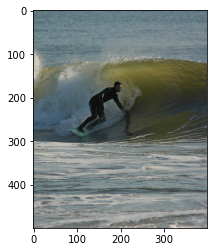

In [246]:
infer(433, xception_model, model, tokenizer, img_feature, max_length)

In [249]:
# Load the image and generate the caption
dataset_keys = json.load(
    open(os.path.join(DATASET_INTERIM, "dataset_keys.json"), "rb")
)

two girls are playing with sparklers
man in black shirt and sunglasses is holding up sign
man in black swimsuit is jumping into the water
man in red shirt is standing on the side of large rock
man in red shirt is jumping his bicycle off ramp
man in black and white top is jumping into the water
dog swims in the water
man in red shirt is jumping off ramp
two dogs are playing with ball in the snow
man in black shirt is standing in front of building
man in black shirt is standing in front of window
dog is running through the grass
two girls are playing with swords in the grass
two people are riding on the beach
dog is jumping into the water
man in blue shirt is riding dirt bike
two girls are sitting on the floor
dog is running through the grass
man in black shirt is skateboarding on the street
two dogs are playing in the snow
dog is running through the grass
man in black shirt and jeans is walking down the street
man in black shirt is sitting on the side of the steps
man in red shirt is st

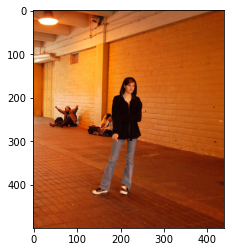

In [251]:
import time

infer_times = []

for i in range(1, 500, 20):
    start_time = time.time()
    infer(i, xception_model, model, tokenizer, img_feature, max_length)
    end_time = time.time()
    infer_time = end_time - start_time
    infer_times.append(infer_time)
    
# Calculate the average infer time
average_infer_time = sum(infer_times) / len(infer_times)

print(f"Average time for each inference: {average_infer_time:.2f} seconds")